In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Dense, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical, pad_sequences
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from data_preprocessing import load_sst
import gensim.downloader as api
import pytreebank

from keras.layers import CuDNNLSTM, SpatialDropout1D, Conv1D
from keras.callbacks import EarlyStopping


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kiann\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_data, train_labels, test_data, test_labels, dev_data, dev_labels = load_sst()

INFO: SST-2 loaded


In [19]:
df_train = pd.DataFrame({'content':train_data, 'sentiment':train_labels})
# df_val = pd.DataFrame({'content':test_data, 'sentiment':test_labels})

In [20]:
# df_train = pd.read_csv('data/stanfordSentimentTreebank/working/sst_train.txt', sep='\t',header=None,names=['sentiment','content'])
# df_train['sentiment'] = df_train['sentiment'].str.replace("__label__","")
# df_train['sentiment'] = df_train['sentiment'].astype(int)#.astype("category")
# df_train['sentiment'] = df_train['sentiment'] - 1
# df_train

# df_val = pd.read_csv('data/stanfordSentimentTreebank/working/sst_test.txt', sep='\t',header=None,names=['sentiment','content'])
# df_val['sentiment'] = df_val['sentiment'].str.replace("__label__","")
# df_val['sentiment'] = df_val['sentiment'].astype(int)#.astype("category")
# df_val['sentiment'] = df_val['sentiment'] - 1
# df_train['sentiment'].map({-1 : 0, 1: 1})
# df_val['sentiment'].map({-1 : 0, 1: 1})
df_train['sentiment'].value_counts()

sentiment
1    37569
0    29780
Name: count, dtype: int64

In [21]:
df_train.reset_index(drop=True, inplace=True)
df_train.head(5)
# df_val.reset_index(drop=True, inplace=True)
# df_val.head(5)


,content,sentiment
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [22]:
df_train['sentiment'].unique()

array([0, 1], dtype=int64)

In [24]:
import torch
import tqdm
import text_hammer as th
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def pre_pro(df):
    # These are series of preprocessing
    df['content'] = df['content'].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df['content'] = df['content'].progress_apply(lambda x: th.remove_emails(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_html_tags(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_urls(x))

    df['content'] = df['content'].progress_apply(lambda x: th.remove_special_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.remove_accented_chars(x))
    df['content'] = df['content'].progress_apply(lambda x: th.make_base(x)) #ran -> run, 
    # df['content'] = df['content'].progress_apply(lambda x: th.spelling_correction(x).raw_sentences[0]) #seplling -> spelling
    print("Number of words with stopwords:",df['content'].str.split().str.len().sum())
    df["content"] = df['content'].progress_apply(lambda x: remove_stopwords(x))
    print("Number of words without stopwords:",df['content'].str.split().str.len().sum())

pre_pro(df_train)
# pre_pro(df_val)




  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

c:\Users\Kiann\miniconda3\envs\tf\lib\site-packages\bs4\__init__.py:329: MarkupResemblesLocatorWarning: "con " looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

  0%|          | 0/67349 [00:00<?, ?it/s]

Number of words with stopwords: 583810


  0%|          | 0/67349 [00:00<?, ?it/s]

Number of words without stopwords: 338193


In [25]:
model_type = 'glove-wiki-gigaword-200'  # 25 100 200 word2vec 300 
wv_path = ['./data/train_data/train', './data/test_data/test']

w2vModel = api.load(model_type)

INFO: loading projection weights from C:\Users\Kiann/gensim-data\glove-wiki-gigaword-200\glove-wiki-gigaword-200.gz
INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 200) matrix of type float32 from C:\\Users\\Kiann/gensim-data\\glove-wiki-gigaword-200\\glove-wiki-gigaword-200.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2024-04-03T00:27:09.094964', 'gensim': '4.3.2', 'python': '3.9.19 (main, Mar 21 2024, 17:21:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'load_word2vec_format'}


In [26]:
GLOVE_DIM = int(model_type.split('-')[-1])

In [27]:
tokenizer = Tokenizer(num_words=30000)
tokenizer.fit_on_texts(df_train['content'])

X_train, X_test, y_train, y_test = train_test_split(df_train['content'], df_train['sentiment'], test_size=0.2, random_state=42, shuffle=True)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Adding 1 because of  reserved 0 index
vocab_size = len(tokenizer.word_index) + 1    
length_of_longest_sentence = len(max(X_train, key=len))
print(length_of_longest_sentence)
maxlen = length_of_longest_sentence # sentence length

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

28


In [28]:
y_train_one_hot = to_categorical(y_train, num_classes=len(df_train['sentiment'].unique()))
y_test_one_hot = to_categorical(y_test, num_classes=len(df_train['sentiment'].unique()))

In [29]:
wordLen = len(tokenizer.word_index)+1
wordLen

12614

In [30]:
## prepare a corresponding embedding matrix that used in a Keras Embedding layer. 
## It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

def embed(model, tokenizer):
    embed_size = GLOVE_DIM
    embedding_matrix = np.zeros((len(tokenizer.word_index)+1, embed_size))

    hits = 0
    misses = 0

    # embedding matrix
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model.get_vector(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                hits += 1
            else:
                misses += 1
        except:
            misses += 1
        
            
    print("Converted %d words (%d misses)" % (hits, misses))
    return embedding_matrix


embedding_matrix = embed (w2vModel, tokenizer)
embedding_matrix

Converted 10931 words (1682 misses)


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.18889   ,  0.19302   , -0.86576003, ...,  0.03805   ,
         0.23120999,  0.35679001],
       [ 0.33201   ,  0.30195001, -0.88213003, ...,  0.075378  ,
         0.39153999,  0.57608998],
       ...,
       [-0.028945  ,  0.31018001,  0.04713   , ...,  0.13456   ,
         0.1165    , -0.22330999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.82804   , -0.27252001, -0.3486    , ..., -0.26808   ,
         0.099554  , -0.54202002]])

In [31]:
model = Sequential()
model.add(Embedding(wordLen, output_dim=GLOVE_DIM, input_length=maxlen, weights=[embedding_matrix],trainable=False))
# model.add(SpatialDropout1D(0.25))
# model.add(Dense(500, activation='relu'))
# model.add(Dense(150, activation='relu'))
# model.add(Conv1D(32, 3))
# model.add(Conv1D(200, 2, activation="relu"))
# model.add(LSTM(units=128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(Dropout(0.5))

model.add(SpatialDropout1D(0.25))
model.add(Conv1D(32, 3))
model.add(Bidirectional(CuDNNLSTM(64,return_sequences=False)))
# model.add(LSTM(units=128, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())
# model.add(Bidirectional(CuDNNLSTM(128,return_sequences=False)))
model.add(Dense(len(df_train['sentiment'].unique()), activation='softmax'))
adam = Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                               patience=0.05)
history = model.fit(X_train, y_train_one_hot, epochs=200, batch_size=32, verbose=1,validation_data=(X_test,y_test_one_hot),callbacks= [es])

print(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 200)           2522800   
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 200)          0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 26, 32)            19232     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              50176     
 l)                                                              
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 2,592,466
Trainable params: 69,666
Non-tra

In [32]:
import matplotlib.pyplot as plt
last_accuracy = "{:.3f}".format(history.history['accuracy'][-1])
print("Training Accuracy:", last_accuracy)

Training Accuracy: 0.907


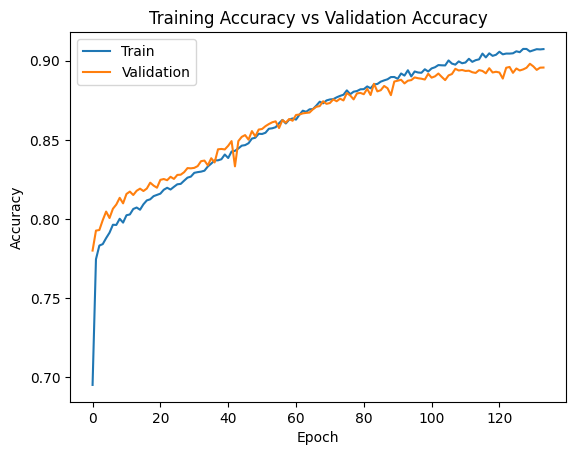

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

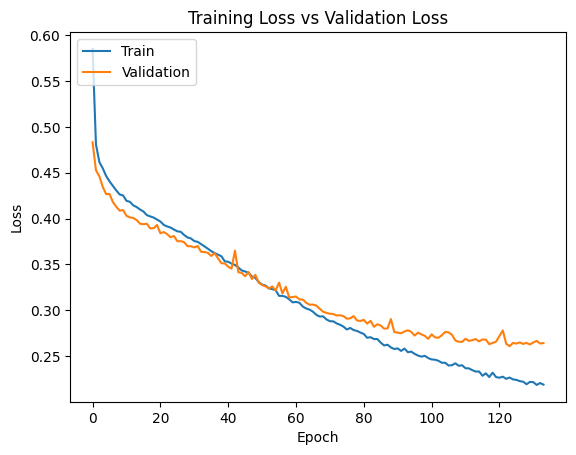

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()